## Setup

In [ ]:
! brew install git python3 cmake sdl2 sdl2_image sdl2_ttf sdl2_gfx boost boost-python3
! python3 -m pip install --upgrade pip setuptools psutil wheel

In [ ]:
! pip install gfootball 

In [ ]:
! pip install setuptools==65.5.0
! git clone https://github.com/google-research/football.git
! cd football && pip install . 

### Test game play

In [127]:
! python -m gfootball.play_game --action_set=full

objc[81026]: Class SDLApplication is implemented in both /opt/homebrew/Cellar/sdl2/2.26.3/lib/libSDL2-2.0.0.dylib (0x106368800) and /Users/georgipachov/opt/miniconda3/envs/rl/lib/python3.10/site-packages/pygame/.dylibs/libSDL2-2.0.0.dylib (0x1321287e8). One of the two will be used. Which one is undefined.
objc[81026]: Class SDLAppDelegate is implemented in both /opt/homebrew/Cellar/sdl2/2.26.3/lib/libSDL2-2.0.0.dylib (0x106368850) and /Users/georgipachov/opt/miniconda3/envs/rl/lib/python3.10/site-packages/pygame/.dylibs/libSDL2-2.0.0.dylib (0x132128838). One of the two will be used. Which one is undefined.
objc[81026]: Class SDLTranslatorResponder is implemented in both /opt/homebrew/Cellar/sdl2/2.26.3/lib/libSDL2-2.0.0.dylib (0x1063688c8) and /Users/georgipachov/opt/miniconda3/envs/rl/lib/python3.10/site-packages/pygame/.dylibs/libSDL2-2.0.0.dylib (0x1321288b0). One of the two will be used. Which one is undefined.
objc[81026]: Class SDLMessageBoxPresenter is implemented in both /opt/h

### Learning environment 

In [1]:
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import gym
import numpy as np
import os
from collections import namedtuple
import gfootball
import gfootball.env as football_env
from gfootball.env.wrappers import Simple115StateWrapper
import collections

SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])

class ShapingRewardWrapper(gym.Wrapper):
        def __init__(self, env):
            super().__init__(env)
            self.observation_space = collections.namedtuple('ObservationSpace', 'shape')
            self.observation_space.shape=(115,)
            self._env = env

            self._bo = 0.02
            
            # attack vs defense coefficients
            self._dist_mg = 0.01
            self._dist_og = 0.01
            
            self._opdist = 0.1
            self._goal_bonus = 100

        
        def step(self, action):
            obs, reward, done, info = self._env.step(action)
            reward *= self._goal_bonus
            obs = obs[0]

            if obs['ball_owned_team'] == 0:
                reward += self._bo
            elif obs['ball_owned_team'] == 1:
                reward -= self._bo

            bx, by, bz = obs['ball']
            mgx, mgy = -1, 0
            ogx, ogy = 1, 0
            
            dist_from_my_goal = (np.sqrt((bx-mgx)**2 + (by-mgy)**2))
            dist_from_opponent_goal = (np.sqrt((bx-ogx)**2 + (by-ogy)**2))
            
            reward += self._dist_mg * dist_from_my_goal
            reward += self._dist_og * dist_from_opponent_goal

            # distance of controlling player from ball 
            mx, my = obs['left_team'][obs['active']]
            if obs['ball_owned_team'] != 0:
                reward -= self._opdist * (np.sqrt((bx-mx)**2 + (by-my)**2))
                
            return obs, reward, done, info

        
def obs_transform(obs):
    return Simple115StateWrapper.convert_observation(obs, True)


def create_env(render=False, 
               env_name='academy_empty_goal', 
               wrapper_init=None,
               record=True,
               **params):
    if env_name == 'cart_pole':
        env = gym.make('CartPole-v0')
    else:
        env_names = ['1_vs_1_easy', '5_vs_5', 'academy_run_to_score', 'academy_empty_goal_close', 'academy_empty_goal']
        os.environ['MESA_GL_VERSION_OVERRIDE'] = '3.3'
        env = football_env.create_environment(env_name=env_name, 
                                              stacked=False, 
                                              representation='raw',
                                              rewards='scoring,checkpoints',
                                              logdir='replays', 
                                              write_goal_dumps=record, 
                                              write_full_episode_dumps=record, 
                                              write_video=record,
                                              render=render)
        if wrapper_init is not None:
            return wrapper_init.__call__(env)
        else:
            return env


class Policy(nn.Module):
    """
    implements both actor and critic in one model
    """
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(115, 128)

        # actor's layer
        self.action_head = nn.Linear(128, 19)

        # critic's layer
        self.value_head = nn.Linear(128, 1)

        # action & reward buffer
        self.saved_actions = []
        self.rewards = []

    def forward(self, x):
        """
        forward of both actor and critic
        """
        x = F.relu(self.affine1(x))

        # actor: choses action to take from state s_t 
        # by returning probability of each action
        action_prob = F.softmax(self.action_head(x), dim=-1)

        # critic: evaluates being in the state s_t
        state_values = self.value_head(x)

        # return values for both actor and critic as a tuple of 2 values:
        # 1. a list with the probability of each action over the action space
        # 2. the value from state s_t 
        return action_prob, state_values


def select_action(model, state):
    state = torch.from_numpy(state).float()
    probs, state_value = model(state)

    # create a categorical distribution over the list of probabilities of actions
    m = Categorical(probs)

    # and sample an action using the distribution
    action = m.sample()

    # save to action buffer
    model.saved_actions.append(SavedAction(m.log_prob(action), state_value))

    return action.item()


def finish_episode(model, optimizer, gamma, eps=1e-8):
    """
    Training code. Calculates actor and critic loss and performs backprop.
    """
    R = 0
    saved_actions = model.saved_actions
    policy_losses = [] # list to save actor (policy) loss
    value_losses = [] # list to save critic (value) loss
    returns = [] # list to save the true values

    # calculate the true value using rewards returned from the environment
    for r in model.rewards[::-1]:
        # calculate the discounted value
        R = r + gamma * R
        returns.insert(0, R)

    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)

    for (log_prob, value), R in zip(saved_actions, returns):
        advantage = R - value.item()

        # calculate actor (policy) loss 
        policy_losses.append(-log_prob * advantage)

        # calculate critic (value) loss using L1 smooth loss
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))

    # reset gradients
    optimizer.zero_grad()

    # sum up all the values of policy_losses and value_losses
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()

    # perform backprop
    loss.backward()
    optimizer.step()

    # reset rewards and action buffer
    del model.rewards[:]
    del model.saved_actions[:]


### Learning objective: Pass to score

In [2]:
class DistanceFromOpponentGoalReward(gym.Wrapper):
        def __init__(self, env):
            super().__init__(env)
            self._env = env
        
        def step(self, action):
            obs, reward, done, info = self._env.step(action)
            reward = 0
            
            obs = obs[0]

            bx, by, bz = obs['ball']
            ogx, ogy = -1, 0
            
            dist_from_opponent_goal = (np.sqrt((bx-ogx)**2 + (by-ogy)**2))
            reward -= dist_from_opponent_goal
            
            return obs, reward, done, info
        
class DistanceFromOpponentGoalRewardFixed(gym.Wrapper):
        def __init__(self, env):
            super().__init__(env)
            self._env = env
        
        def step(self, action):
            obs, reward, done, info = self._env.step(action)
            reward = 0
            
            obs = obs[0]

            bx, by, bz = obs['ball']
            ogx, ogy = 1, 0
            
            dist_from_opponent_goal = (np.sqrt((bx-ogx)**2 + (by-ogy)**2))
            reward -= dist_from_opponent_goal
            
            return obs, reward, done, info

In [3]:
def run_agent(exp_name='exp1',
              model=None,
              train=True,
              render=False,
              record=False, 
              num_episodes=2000,
              num_steps=500,
              task='academy_empty_goal_close',
              wrapper_init=DistanceFromOpponentGoalReward,
              policy_fn=Policy,
              solved_threshold=-25,
              log_every=50,
              learning_rate=1e-2,
              gamma=0.99,
              last_n=5,
              seed=0,
              checkpoint=True,
              checkpoint_dir='checkpoints'
             ):
    # set seed first
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    if not os.path.exists(checkpoint_dir):
        os.mkdir(checkpoint_dir)
    
    try: 
        max_reward = -1_000_000
        running_reward = 0
        episode_rewards = []
        env = create_env(render=render, 
                         env_name=task,
                         record=record,
                         wrapper_init=wrapper_init)
        if model is None:
            model = policy_fn()
            
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        # eps = np.finfo(np.float32).eps.item()
        eps = 1e-8

        # run inifinitely many episodes
        for i_episode in range(num_episodes):
            # reset environment and episode reward
            state = env.reset()
            state = obs_transform(state)
            ep_reward = 0

            # for each episode, only run 9999 steps so that we don't 
            # infinite loop while learning
            for t in range(1, num_steps):

                # select action from policy
                action = select_action(model, state)

                # take the action
                state, reward, done, _ = env.step(action)
                state = obs_transform([state])

                model.rewards.append(reward)
                ep_reward += reward
                if done:
                    break

                    
            # log results
            episode_rewards.append(ep_reward)
            
            # update cumulative reward
            running_reward = np.mean(episode_rewards[-last_n:])
            
            if i_episode % log_every == 0:
                print(f'Episode: {i_episode}\tLast reward: {ep_reward:.2f} \t Last {last_n} episodes average reward: {running_reward}')

            if train:
                # save checkpoint
                if checkpoint:
                    if running_reward > max_reward:
                        torch.save(model, f'{checkpoint_dir}/{running_reward}_{task}_{exp_name}_checkpoint_{i_episode}.h5')
                        max_reward = running_reward

                if i_episode > last_n and running_reward > solved_threshold:
                    torch.save(model, f'{task}_{exp_name}.h5')
                    print('Solved!')
                    return model, episode_rewards
                
                else:
                    # perform backprop
                    finish_episode(model, optimizer, gamma)
                
        return model, episode_rewards
    finally: 
        env.close()
        
def load_best_agent(checkpoints_dir='checkpoints'):
    # Load best agent
    checkpoints = os.listdir(checkpoints_dir)
    all_checkpoints = {int(x[:x.index('.')]):x for x in checkpoints}
    max_reward = max(all_checkpoints.keys())
    best = all_checkpoints[max_reward]
    print('Loading checkpoint: ', best)
    model_loaded = torch.load(os.path.join(checkpoints_dir, best))
    return model_loaded

def load_agent(name, checkpoints_dir='checkpoints'):
    # Load manually
    print('Loading checkpoint: ', name)
    model_loaded = torch.load(os.path.join(checkpoints_dir, name))
    return model_loaded

### Pass and score

In [4]:
model, episode_rewards = run_agent(train=True, 
                                   render=False, 
                                   record=False, 
                                   log_every=50, 
                                   seed=42, 
                                   last_n=10, 
                                   solved_threshold=-10, 
                                   task='academy_pass_and_shoot_with_keeper', 
                                   learning_rate=3e-1,
                                   wrapper_init=DistanceFromOpponentGoalRewardFixed)

Episode: 0	Last reward: -19.33 	 Last 10 episodes average reward: -19.331357444546537


/var/folders/4x/vb5tl80s45v2f_k7_zb004bc0000gn/T/ipykernel_235/1773448652.py:171: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))


Solved!


<AxesSubplot: title={'center': 'Mean reward for last 20 episodes'}, xlabel='Еpisode', ylabel='Reward'>

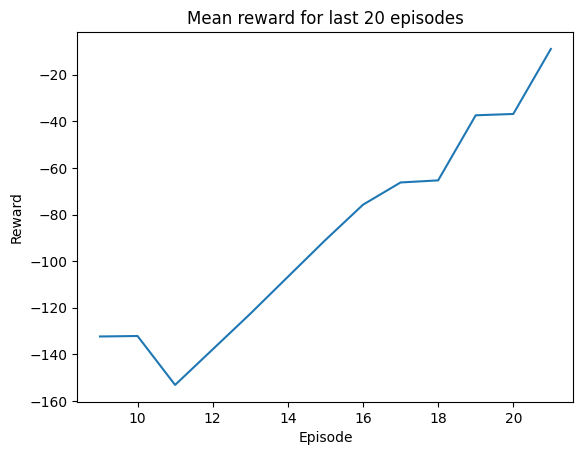

In [5]:
pd.Series(episode_rewards).rolling(10).mean().plot(xlabel='Еpisode', ylabel='Reward', title='Mean reward for last 20 episodes')

In [6]:
run_agent(model=model, 
          train=False, 
          render=True, 
          record=True,
          seed=42, 
          num_episodes=13,
          task='academy_pass_and_shoot_with_keeper', 
          wrapper_init=DistanceFromOpponentGoalRewardFixed)

UNSUPPORTED (log once): POSSIBLE ISSUE: unit 1 GLD_TEXTURE_INDEX_2D is unloadable and bound to sampler type (Float) - using zero texture because texture unloadable


Episode: 0	Last reward: -6.12 	 Last 5 episodes average reward: -6.123853372998049


(Policy(
   (affine1): Linear(in_features=115, out_features=128, bias=True)
   (action_head): Linear(in_features=128, out_features=19, bias=True)
   (value_head): Linear(in_features=128, out_features=1, bias=True)
 ),
 [-6.123853372998049,
  -13.247375579036731,
  -11.016500679855115,
  -9.553018963354065,
  -11.307863274428499,
  -10.57691847940186,
  -6.13373212931946,
  -13.45337437273798,
  -6.466018880307951,
  -6.467615147861508,
  -6.13482105185624,
  -6.405752655140846,
  -11.851276030745256])

In [148]:
# https://github.com/google-research/football/blob/master/gfootball/doc/observation.md#raw-observations

In [ ]:
# academy_empty_goal_close
# academy_empty_goal
# academy_run_to_score
# academy_run_to_score_with_keeper

In [ ]:
#         academy_pass_and_shoot_with_keeper - Two of our players try to score from the edge of the box, one is on the side with the ball, and next to a defender. The other is at the center, unmarked, and facing the opponent keeper.
#         academy_run_pass_and_shoot_with_keeper - Two of our players try to score from the edge of the box, one is on the side with the ball, and unmarked. The other is at the center, next to a defender, and facing the opponent keeper.
#         academy_3_vs_1_with_keeper - Three of our players try to score from the edge of the box, one on each side, and the other at the center. Initially, the player at the center has the ball and is facing the defender. There is an opponent keeper.
#         academy_corner - Standard corner-kick situation, except that the corner taker can run with the ball from the corner.
#         academy_counterattack_easy - 4 versus 1 counter-attack with keeper; all the remaining players of both teams run back towards the ball.
#         academy_counterattack_hard - 4 versus 2 counter-attack with keeper; all the remaining players of both teams run back towards the ball.
#         academy_single_goal_versus_lazy - Full 11 versus 11 games, where the opponents cannot move but they can only intercept the ball if it is close enough to them. Our center back defender has the ball at first.

